## hardware

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
ad

In [ ]:
!nvidia-smi

Sat Oct 12 07:18:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## kaggle

In [ ]:
import os

if not os.path.isdir('/content/train_images/'):
    !unzip '/content/drive/MyDrive/Kaggle/RSNA 2024 Lumbar Spine Degenerative Classification/DataSources/rsna-2024-lumbar-spine-degenerative-classification.zip'

## library

In [ ]:
!pip install albumentations pydicom segmentation_models_pytorch timm transformers

In [ ]:
import numpy as np
import pandas as pd

import random

import os

import glob

from tqdm import tqdm

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

import cv2

import shutil

from google.colab import runtime

import torch
import torch.nn as nn
import torch.nn.functional as F

import albumentations as A

import pydicom

import timm

from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
from transformers import RobertaPreLayerNormConfig, RobertaPreLayerNormModel

from scipy.ndimage import gaussian_filter

from segmentation_models_pytorch.decoders.unet.model import (
    UnetDecoder,
    SegmentationHead,
)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## config

In [ ]:
class CustomConfig:
    seed = 42
    device = 'cuda'
    root = '/content/drive/MyDrive/Kaggle/RSNA 2024 Lumbar Spine Degenerative Classification/'

    scan_orientations = ['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2']

    n_fold = 5

    batch_size = 4
    n_worker = os.cpu_count()

    coordinate_columns = {
        'Sagittal T2/STIR' : [
            ['Spinal Canal Stenosis', 'L1/L2'],
            ['Spinal Canal Stenosis', 'L2/L3'],
            ['Spinal Canal Stenosis', 'L3/L4'],
            ['Spinal Canal Stenosis', 'L4/L5'],
            ['Spinal Canal Stenosis', 'L5/S1'],
        ],
        'Sagittal T1' : [
            ['Left Neural Foraminal Narrowing', 'L1/L2'],
            ['Left Neural Foraminal Narrowing', 'L2/L3'],
            ['Left Neural Foraminal Narrowing', 'L3/L4'],
            ['Left Neural Foraminal Narrowing', 'L4/L5'],
            ['Left Neural Foraminal Narrowing', 'L5/S1'],

            ['Right Neural Foraminal Narrowing', 'L1/L2'],
            ['Right Neural Foraminal Narrowing', 'L2/L3'],
            ['Right Neural Foraminal Narrowing', 'L3/L4'],
            ['Right Neural Foraminal Narrowing', 'L4/L5'],
            ['Right Neural Foraminal Narrowing', 'L5/S1'],
        ],
        'Axial T2' : [
            ['Left Subarticular Stenosis', 'L1/L2'],
            ['Left Subarticular Stenosis', 'L2/L3'],
            ['Left Subarticular Stenosis', 'L3/L4'],
            ['Left Subarticular Stenosis', 'L4/L5'],
            ['Left Subarticular Stenosis', 'L5/S1'],

            ['Right Subarticular Stenosis', 'L1/L2'],
            ['Right Subarticular Stenosis', 'L2/L3'],
            ['Right Subarticular Stenosis', 'L3/L4'],
            ['Right Subarticular Stenosis', 'L4/L5'],
            ['Right Subarticular Stenosis', 'L5/S1'],
        ],
    }

if __name__ == "__main__":
    args = CustomConfig()

## seed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

if __name__ == "__main__":
    seed_everything(args.seed)

## preprocess

In [ ]:
def preprocess(args):
    train = pd.read_csv('/content/train.csv')

    folds = []

    kf = KFold(n_splits = args.n_fold, shuffle = True, random_state = args.seed)
    for train_indices, test_indices in kf.split(train):

        train_df = train.loc[train_indices].reset_index(drop = True)
        test_df = train.loc[test_indices].reset_index(drop = True)

        folds.append([train_df, test_df])

    return train, folds

if __name__ == "__main__":
    train, folds = preprocess(args)

## utils

In [ ]:
def volume2point(volumes):
    volumes = volumes.cpu()

    batch_size, n_class, _, h, w = volumes.shape

    points = []
    for i in range(batch_size):
        volume = volumes[i]

        point = []
        for j in range(n_class):
            flat_volume = volume[j].reshape(-1)
            max_idx = torch.argmax(flat_volume)

            z = max_idx // (h * w)
            y = (max_idx % (h * w)) // w
            x = (max_idx % (h * w)) % w
            point.append(torch.stack([z, y, x]))

        point = torch.stack(point, dim = 0)
        points.append(point)

    points = torch.stack(points, dim = 0)
    return points.numpy()

## dataset

In [ ]:
def convert_to_8bit(x):
    lower, upper = np.percentile(x, (1, 99))
    x = np.clip(x, lower, upper)
    x = x - np.min(x)
    x = x / np.max(x)
    return (x * 255).astype("uint8")

def get_imgs(dcms):
    imgs = []
    for dcm in dcms:
        img = convert_to_8bit(dcm.pixel_array)
        imgs.append(img)

    try:
        return np.stack(imgs, axis = 0)
    except:
        h, w = imgs[0].shape
        imgs = [A.Resize(h, w)(image = x)['image'] for x in imgs]
        return np.stack(imgs, axis = 0)

inputs :  torch.Size([32, 256, 256])
targets :  torch.Size([5, 32, 256, 256])
masks :  torch.Size([5, 32])
[[[ 11 106 146]
  [ 11 128 135]
  [ 11 148 132]
  [ 11 169 142]
  [ 11 183 154]]]


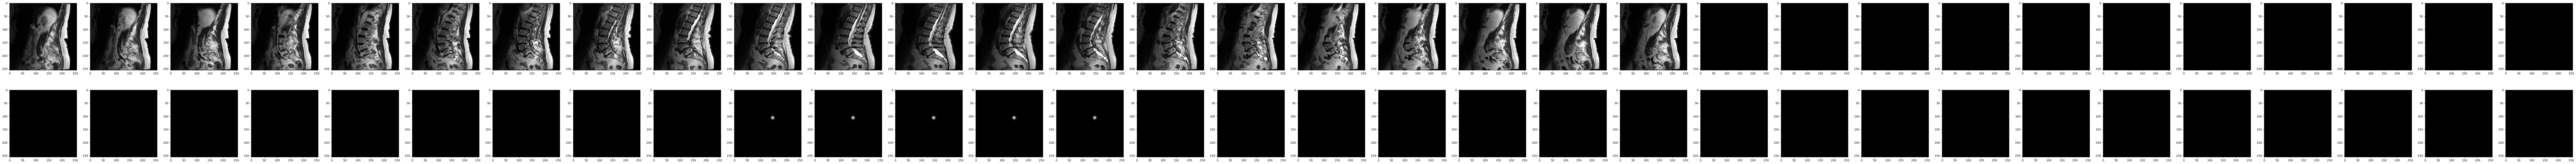

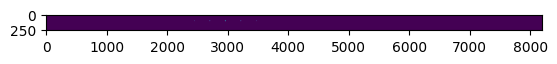

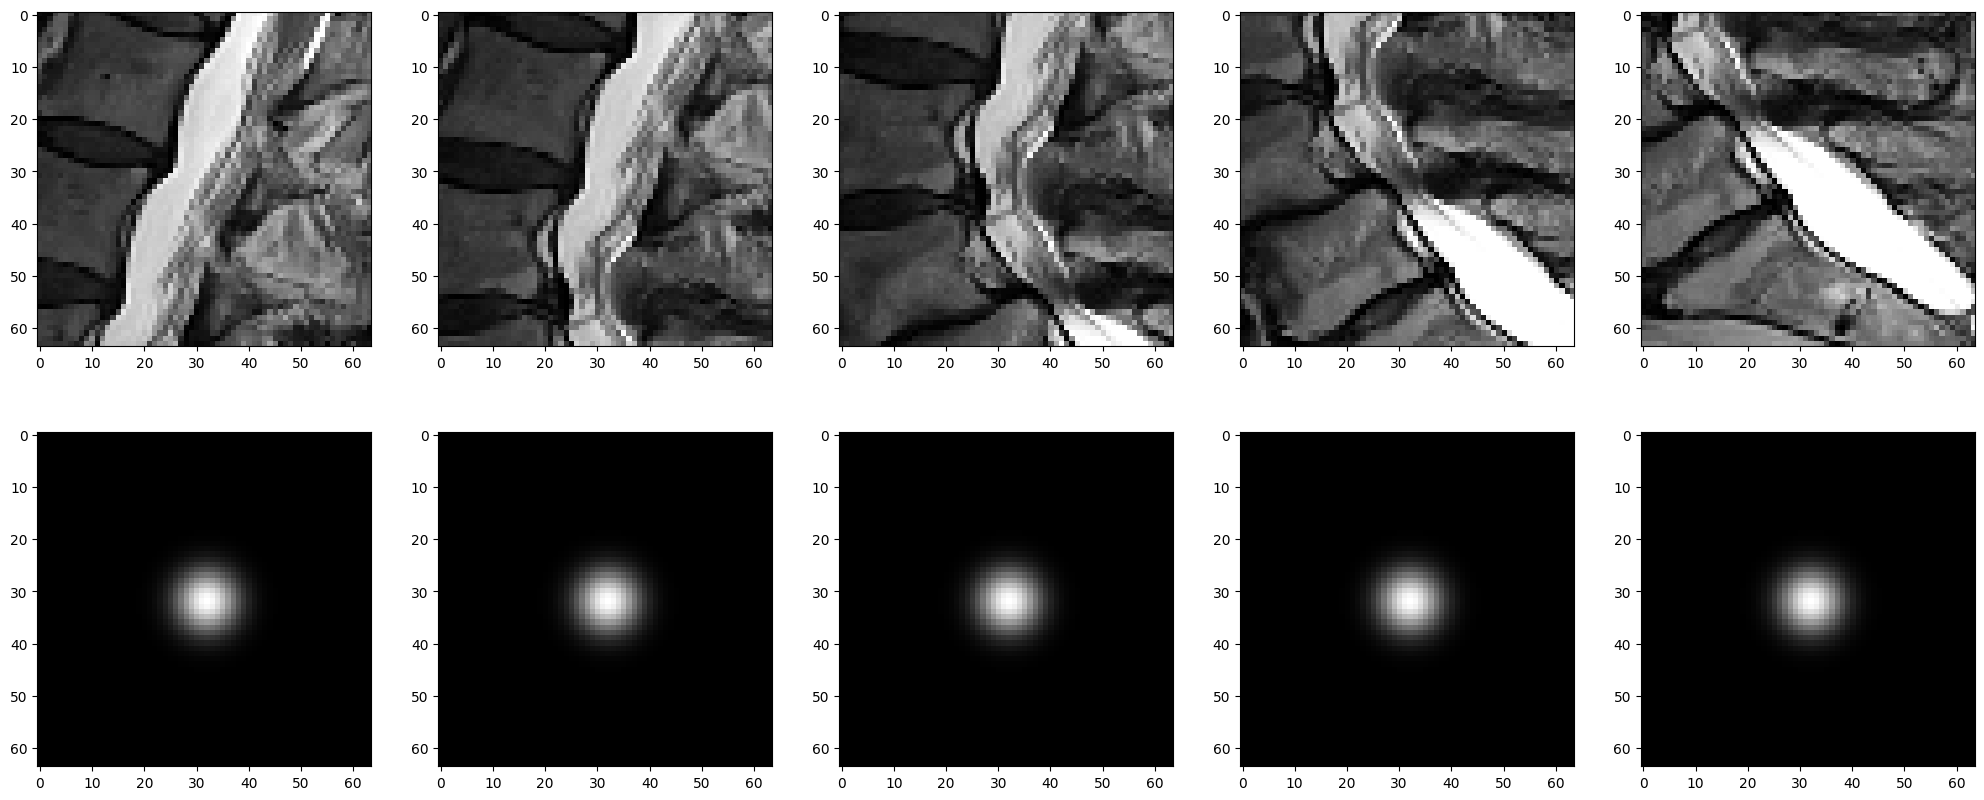

In [ ]:
class DetectDataset(torch.utils.data.Dataset):
    def __init__(self, args, df, orientation):
        self.args = args
        self.df = df
        self.orientation = orientation

        self.volume_size = {
            'Sagittal T2/STIR' : [32, 256, 256],
            'Sagittal T1' : [32, 256, 256],
            'Axial T2' : [64, 256, 256]
        }[orientation]

        self.train_series_descriptions = pd.read_csv('/content/train_series_descriptions.csv')
        self.train_label_coordinates = pd.read_csv('/content/train_label_coordinates.csv')

    def __len__(self):
        return len(self.df)

    def get_inputs(self, study_id, series_id):
        dicoms = sorted(glob.glob(f'/content/train_images/{study_id}/{series_id}/*.dcm'), key = lambda x: int(x.split('/')[-1].split('.')[0]))
        dicoms = [pydicom.dcmread(x) for x in dicoms]

        inputs = get_imgs(dicoms)

        if 'Sagittal' in self.orientation:
            pos = np.asarray([d.ImagePositionPatient for d in dicoms])[:, 0]
        else:
            pos = np.asarray([d.ImagePositionPatient for d in dicoms])[:, -1]

        inputs = A.Resize(self.volume_size[1], self.volume_size[2])(image = inputs.transpose(1, 2, 0))['image'].transpose(2, 0, 1)
        inputs = torch.tensor(inputs, dtype = torch.float)
        inputs = inputs / 255.0
        return inputs, pos

    def get_targets(self, study_id, series_id, sigma = 4):
        dicoms = sorted(glob.glob(f'/content/train_images/{study_id}/{series_id}/*.dcm'), key = lambda x: int(x.split('/')[-1].split('.')[0]))
        instance_numbers = [int(x.split('/')[-1].split('.')[0]) for x in dicoms]
        instance2index = dict(zip(instance_numbers, [i for i in range(len(instance_numbers))]))

        targets = np.zeros([len(self.args.coordinate_columns[self.orientation])] + [len(dicoms)] + self.volume_size[1:], dtype = np.float32)

        label_coordinate = self.train_label_coordinates[(self.train_label_coordinates['study_id'] == study_id) & (self.train_label_coordinates['series_id'] == series_id)].reset_index(drop = True)
        for i in range(len(self.args.coordinate_columns[self.orientation])):
            try:
                condition, level = self.args.coordinate_columns[self.orientation][i][0], self.args.coordinate_columns[self.orientation][i][1]
                _, _, instance_number, _, _, x, y = label_coordinate[(label_coordinate['condition'] == condition) & (label_coordinate['level'] == level)].reset_index(drop = True).loc[0]
                h, w = pydicom.dcmread(f'/content/train_images/{study_id}/{series_id}/{instance_number}.dcm').pixel_array.shape
                z = instance2index[instance_number]

                z_i = z
                y_i = round(y * (self.volume_size[1] / h))
                x_i = round(x * (self.volume_size[2] / w))

                targets[i, z_i, y_i, x_i] = 1

                targets[i, z_i] = gaussian_filter(targets[i, z_i], sigma = (sigma, sigma))
                targets[i, z_i] = targets[i, z_i] / targets[i, z_i].max()

                targets[i, max(0, z_i - 2)] = targets[i, z_i] / 2**2
                targets[i, max(0, z_i - 1)] = targets[i, z_i] / 2**1

                targets[i, min(targets.shape[1] - 1, z_i + 2)] = targets[i, z_i] / 2**2
                targets[i, min(targets.shape[1] - 1, z_i + 1)] = targets[i, z_i] / 2**1
            except: pass

        targets = torch.tensor(targets, dtype = torch.float)
        return targets

    def get_multiples(self, row):
        row_series_descriptions = self.train_series_descriptions[self.train_series_descriptions['study_id'] == row['study_id']]
        row_series_descriptions = row_series_descriptions[row_series_descriptions['series_description'] == self.orientation].reset_index(drop = True)

        if len(row_series_descriptions) > 0:
            inputs, pos, targets = [], [], []
            for i in range(len(row_series_descriptions)):
                study_id, series_id, _ = row_series_descriptions.loc[i]

                _inputs, _pos = self.get_inputs(study_id, series_id)
                _targets = self.get_targets(study_id, series_id)

                inputs.append(_inputs)
                pos.append(_pos)
                targets.append(_targets)

            inputs = torch.cat(inputs, dim = 0)
            pos = np.concatenate(pos, axis = 0)
            targets = torch.cat(targets, dim = 1)
        else:
            inputs = torch.zeros(self.volume_size, dtype = torch.float32)
            pos = np.zeros([self.volume_size[0]], dtype = np.float32)
            targets = torch.zeros([len(self.args.coordinate_columns[self.orientation])] + self.volume_size, dtype = torch.float32)

        return inputs, pos, targets


    def get_masks(self, inputs, targets):
        temporal_masks = (inputs.sum(dim = [1, 2]) != 0).float()
        spatial_masks = (targets.sum(dim = [1, 2, 3]) != 0).float()

        masks = temporal_masks[None, :] * spatial_masks[:, None]
        return masks

    def __getitem__(self, index):
        row = self.df.loc[index]
        inputs, pos, targets = self.get_multiples(row)

        pos = np.argsort(pos)

        inputs = inputs[pos]
        targets = targets[:, pos]

        if inputs.shape[0] > self.volume_size[0]:
            inputs = F.interpolate(inputs.unsqueeze(0).unsqueeze(0), size = self.volume_size, mode = 'trilinear').squeeze(0).squeeze(0)
            targets = F.interpolate(targets.unsqueeze(0), size = self.volume_size, mode = 'trilinear').squeeze(0)

        inputs = torch.cat([inputs, torch.zeros([self.volume_size[0] - inputs.shape[0]] + list(inputs.shape[1:]), dtype = torch.float)], dim = 0)
        targets = torch.cat([targets, torch.zeros([len(self.args.coordinate_columns[self.orientation])] + [self.volume_size[0] - targets.shape[1]] + list(inputs.shape[1:]), dtype = torch.float)], dim = 1)

        masks = self.get_masks(inputs, targets)
        return inputs, targets, masks

if __name__ == "__main__":
    train_df, test_df = folds[0]
    orientation = 'Sagittal T2/STIR'

    dataset = DetectDataset(args, train_df, orientation = orientation)

    index = random.randint(0, len(dataset) - 1)
    inputs, targets, masks = dataset[index]

    print('inputs : ', inputs.shape)
    print('targets : ', targets.shape)
    print('masks : ', masks.shape)

    print(volume2point(targets[None]))

    fig, axes = plt.subplots(2, targets[0].shape[0], figsize = (5 * targets[0].shape[0], 5 * 2))
    for i in range(targets[0].shape[0]):
        axes[0, i].imshow(inputs[i], cmap = 'gray')
        axes[1, i].imshow(targets[0][i], cmap = 'gray')
    plt.show()
    plt.imshow(targets[0].permute(1, 0, 2).reshape(256, -1))
    plt.show()

    patch_size = {'Sagittal T2/STIR' : 32, 'Sagittal T1' : 32, 'Axial T2' : 32}[orientation]
    fig, axes = plt.subplots(2, targets.shape[0], figsize = (5 * targets.shape[0], 5 * 2))

    points = volume2point(targets[None])[0]
    for i in range(targets.shape[0]):
        z, y, x = points[i]
        if points[i].sum() != 0:
            axes[0, i].imshow(inputs[z, y-patch_size:y+patch_size, x-patch_size:x+patch_size], cmap = 'gray')
            axes[1, i].imshow(targets[i][z, y-patch_size:y+patch_size, x-patch_size:x+patch_size], cmap = 'gray')
    plt.show()

## model

In [ ]:
class Segmenter(nn.Module):
    def __init__(self,
                 n_class,
                 n_channel,
                 volume_size,
                 ):
        super(Segmenter, self).__init__()
        self.args = args

        self.n_class = n_class
        self.n_channel = n_channel
        self.volume_size = volume_size

        self.extracter = timm.create_model(
            model_name = 'regnety_002',
            pretrained = True,
            features_only = True,
            in_chans = n_channel,
        )

        encoder_channels = [n_channel] + [self.extracter.feature_info[i]["num_chs"] for i in range(len(self.extracter.feature_info))]
        decoder_channels = [256, 128, 64, 32, 16]

        self.decoder = UnetDecoder(
            encoder_channels = encoder_channels,
            decoder_channels = decoder_channels,
            n_blocks = 5,
            use_batchnorm = True,
            center = False,
            attention_type = None,
        )

        self.head = SegmentationHead(
            in_channels = decoder_channels[-1],
            out_channels = self.n_class,
            activation = None,
            kernel_size= 3,
        )

    def forward(self, x):
        x = x.reshape(-1, self.n_channel, self.volume_size[1], self.volume_size[2])
        _x = self.extracter(x)

        x = self.decoder(*[x] + _x)
        x = self.head(x)

        x = x.reshape(-1, self.volume_size[0], self.n_class, self.volume_size[1], self.volume_size[2])
        x = x.permute(0, 2, 1, 3, 4)
        return x

In [ ]:
class Pointer(nn.Module):
    def __init__(self,
                 n_class,
                 n_channel,
                 volume_size,
                 hidden_size,
                 drop_rate,
                 ):
        super(Pointer, self).__init__()
        self.args = args

        self.n_channel = n_channel
        self.volume_size = volume_size

        self.extracter = timm.create_model(
            model_name = 'regnety_002',
            pretrained = True,
            features_only = True,
            in_chans = n_channel,
        )

        self.dense_size = self.extracter.feature_info[-1]["num_chs"]

        self.dense = nn.Linear(self.dense_size, hidden_size)

        self.rnn = nn.LSTM(
            input_size = self.dense_size,
            hidden_size = hidden_size,
            batch_first = True,
            bidirectional = True
            )

        self.out = nn.Sequential(
            nn.Dropout(p = drop_rate),
            nn.Linear(2 * hidden_size, n_class)
        )

    def forward(self, x, mask):
        x = x.reshape(-1, self.n_channel, self.volume_size[1], self.volume_size[2])
        x = self.extracter(x)
        x = x[-1].mean(dim = [2, 3])

        x = x.reshape(-1, self.volume_size[0], self.dense_size)
        x, _ = self.rnn(x)
        x = self.out(x)

        x = x.permute(0, 2, 1)
        return x

In [ ]:
class DetectModel(nn.Module):
    def __init__(self,
                 args,
                 orientation,
                 n_channel = 3,
                 hidden_size = 256,
                 drop_rate = 0.3,
                 ):

        super(DetectModel, self).__init__()
        self.args = args

        self.orientation = orientation

        n_class = {
            'Sagittal T2/STIR' : 5,
            'Sagittal T1' : 10,
            'Axial T2' : 10,
        }[orientation]

        volume_size = {
            'Sagittal T2/STIR' : [32, 256, 256],
            'Sagittal T1' : [32, 256, 256],
            'Axial T2' : [64, 256, 256]
        }[orientation]

        self.n_channel = n_channel
        self.volume_size = volume_size

        self.segmenter = Segmenter(
            n_class = n_class,
            n_channel = n_channel,
            volume_size = volume_size,
            )

        self.pointer = Pointer(
            n_class = n_class,
            n_channel = n_channel,
            volume_size = volume_size,
            hidden_size = hidden_size,
            drop_rate = drop_rate,
        )

    def get_inputs(self, x):
        x = F.pad(x, (0, 0, 0, 0, (self.n_channel-1)//2, (self.n_channel-1)//2), "constant", 0)
        x = [x[:, i:i+self.n_channel] for i in range(self.volume_size[0])]
        x = torch.stack(x, dim = 1)
        return x

    def get_masks(self, x):
        x = (x.sum(dim = [2, 3]) != 0).float()
        return x

    def get_outputs(self, x1, x2, mask):
        x1 = torch.sigmoid(x1)
        x2 = torch.sigmoid(x2)

        x = x1 * x2[:, :, :, None, None] * mask[:, None, :, None, None]
        return x

    def forward(self, x):
        mask = self.get_masks(x)

        x = self.get_inputs(x)

        x1 = self.segmenter(x)

        x2 = self.pointer(x, mask)

        return x1, x2, self.get_outputs(x1, x2, mask)

if __name__ == "__main__":
    loader = torch.utils.data.DataLoader(dataset, batch_size = args.batch_size, num_workers = args.n_worker)
    sample = next(iter(loader))
    sample = [x.to(args.device) for x in sample]

    model = DetectModel(args, orientation = orientation)
    model = model.to(args.device)

    with torch.no_grad():
        outputs1, outputs2, outputs = model(sample[0])
        print(outputs1.shape)
        print(outputs2.shape)
        print(outputs.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


torch.Size([4, 5, 32, 256, 256])
torch.Size([4, 5, 32])
torch.Size([4, 5, 32, 256, 256])


## inference

In [ ]:
def inference(args, model, loader):
    model.eval()

    preds = np.zeros([len(loader.dataset.df), len(args.coordinate_columns[loader.dataset.orientation]), 3], dtype = int)
    trues = np.zeros([len(loader.dataset.df), len(args.coordinate_columns[loader.dataset.orientation]), 3], dtype = int)
    masks = np.zeros([len(loader.dataset.df), len(args.coordinate_columns[loader.dataset.orientation])], dtype = int)
    for bi, sample in enumerate(tqdm(loader)):
        sample = [x.to(args.device) for x in sample]

        inputs = sample[0]
        targets = sample[1]
        _masks = sample[2]
        with torch.no_grad():
            _, _, outputs = model(inputs)

        preds[(bi) * args.batch_size:(bi + 1) * args.batch_size, :, :] = volume2point(outputs)
        trues[(bi) * args.batch_size:(bi + 1) * args.batch_size, :, :] = volume2point(targets)
        masks[(bi) * args.batch_size:(bi + 1) * args.batch_size, :] = (_masks.sum(2) != 0).long().cpu().numpy()

    return preds, trues, masks

if __name__ == "__main__":
    args = CustomConfig()

    for mode in ['train', 'test']:
        for orientation in args.scan_orientations:
            print('orientation : ', orientation)

            sagittal_t2_weights = sorted(glob.glob('/content/drive/MyDrive/Kaggle/RSNA 2024 Lumbar Spine Degenerative Classification/stage1/sagittal_t2/fold1/*.bin'))
            sagittal_t1_weights = sorted(glob.glob('/content/drive/MyDrive/Kaggle/RSNA 2024 Lumbar Spine Degenerative Classification/stage1/sagittal_t1/fold1/*.bin'))
            axial_t2_weights = sorted(glob.glob('/content/drive/MyDrive/Kaggle/RSNA 2024 Lumbar Spine Degenerative Classification/stage1/axial_t2/fold1/*.bin'))

            if mode == 'train':
                model_weight = {
                    'Sagittal T2/STIR' : sagittal_t2_weights[len(sagittal_t2_weights)//2],
                    'Sagittal T1' : sagittal_t1_weights[len(sagittal_t1_weights)//2],
                    'Axial T2' : axial_t2_weights[len(axial_t2_weights)//2],
                }[orientation]
            else:
                model_weight = {
                    'Sagittal T2/STIR' : sagittal_t2_weights[-1],
                    'Sagittal T1' : sagittal_t1_weights[-1],
                    'Axial T2' : axial_t2_weights[-1],
                }[orientation]

            save_name = {
                'Sagittal T2/STIR' : f'sagittal_t2',
                'Sagittal T1' : f'sagittal_t1',
                'Axial T2' : f'axial_t2',
            }[orientation]

            model = DetectModel(args, orientation)
            model = model.to(args.device)
            model.load_state_dict(torch.load(model_weight))
            model.eval()

            print(orientation, mode, model_weight)

            train_df, test_df = folds[0]
            df = train_df if mode == 'train' else test_df

            dataset = DetectDataset(args, df, orientation)
            loader = torch.utils.data.DataLoader(dataset,
                                                batch_size = args.batch_size,
                                                num_workers = args.n_worker,
                                                shuffle = False,
                                                drop_last = False)

            preds, trues, masks = inference(args, model, loader)

            errors = np.abs(preds - trues)
            z_diff = (errors[:, :, 0] * masks).sum() / masks.sum()
            y_diff = (errors[:, :, 1] * masks).sum() / masks.sum()
            x_diff = (errors[:, :, 2] * masks).sum() / masks.sum()
            distance = (np.sqrt((errors ** 2).sum(2)) * masks).sum() / masks.sum()

            score_dicts = {
                'zyx mean difference' : (z_diff + y_diff + x_diff) / 3,
                'z-axis difference' : z_diff,
                'y-axis difference' : y_diff,
                'x-axis difference' : x_diff,
                'distance' : distance
            }

            print(score_dicts)

            np.save('/content/drive/MyDrive/Kaggle/RSNA 2024 Lumbar Spine Degenerative Classification/DataSources/' + save_name + f'_preds_{mode}.npy', preds)
            np.save('/content/drive/MyDrive/Kaggle/RSNA 2024 Lumbar Spine Degenerative Classification/DataSources/' + save_name + f'_trues_{mode}.npy', trues)
            np.save('/content/drive/MyDrive/Kaggle/RSNA 2024 Lumbar Spine Degenerative Classification/DataSources/' + save_name + f'_masks_{mode}.npy', masks)

            del preds, trues, masks